# Sistem Rekomendasi Anime
Oleh : Putri Nur Fadillah
Sumber Dataset : [Anime Recommendations Database](https://www.kaggle.com/datasets/CooperUnion/anime-recommendations-database)

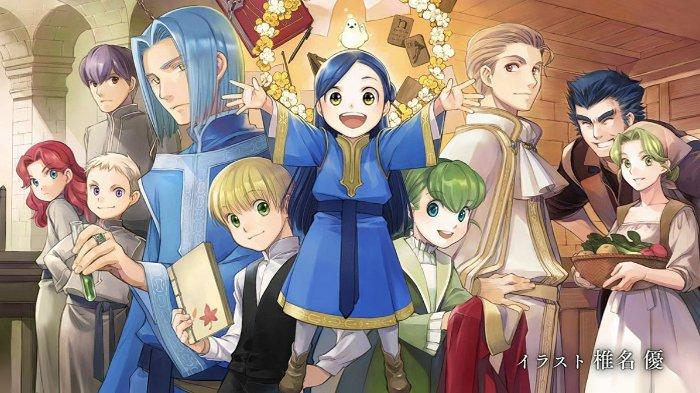
### Latar Belakang Proyek
Anime merupakan animasi yang berasal dari negara Jepang yang digambar dengan tangan maupun menggunakan teknologi komputer. Kata anime merupakan singkatan dari animation dalam bahasa Inggris, yang merujuk pada semua jenis animasi. Di luar Jepang, istilah ini digunakan secara spesifik untuk menyebutkan segala animasi yang diproduksi di negara Jepang. Seiring berjalannya waktu, popularitas anime berkembang dengan pesat secara global. Platform striming dan distribusi anime seperti Crunchyroll, Funimation, dan Netflix mengalami pertumbuhan yang signifikan. Menurut laporan Statista (2024), pasar streaming anime diperkirakan akan mencapai $30 miliar pada tahun 2030 dengan tingkat pertumbuhan tahunan CAGR sebesar 9,6%. Hal ini menunjukkan tingginya minat konsumen terhadap anime sebagai salah satu bentuk hiburan utama.  
Dengan banyaknya jumlah dan keberagaman anime yang tersedia sering kali membuay pengguna kesulitan menemukan konten yang sesuai dengan preferensi mereka. Hal ini bisa saja dipengaruhi oleh keterbatasanya deskripsi dan ulasan pengguna.
Berdasarkan permasalahan yang telah diidentifikasi, penelitian ini bertujuan untuk mengembangkan sebuah sistem yang mampu memberikan rekomendasi anime secara personal kepada pengguna. Sistem ini akan bekerja dengan menganalisis kesamaan antara preferensi pengguna terhadap anime yang telah mereka tonton sebelumnya, sehingga rekomendasi yang dihasilkan lebih relevan dan sesuai dengan minat pengguna.


# Data Collection

**Import Library**

In [ ]:
!pip install -q kaggle

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import re
import matplotlib.pyplot as plt

from google.colab import files
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import calinski_harabasz_score, davies_bouldin_score


In [ ]:
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"putrinurfadillah","key":"73cd1638eeca0ea81015eef5459ddfcb"}'}

In [ ]:
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

cp: cannot create regular file '/root/.kaggle/': Not a directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [ ]:
!kaggle datasets download -d CooperUnion/anime-recommendations-database

Dataset URL: https://www.kaggle.com/datasets/CooperUnion/anime-recommendations-database
License(s): CC0-1.0
 88% 22.0M/25.0M [00:02<00:00, 17.2MB/s]
100% 25.0M/25.0M [00:02<00:00, 11.3MB/s]


In [ ]:
!unzip /content/anime-recommendations-database.zip

Archive:  /content/anime-recommendations-database.zip
  inflating: anime.csv               
  inflating: rating.csv              


Setelah ekstrak file zip terdapat 2 file csv yaitu `anime.csv` dan `rating.csv`. Tetapi pada proyek ini hanya menggunakan file `anime.csv`

In [ ]:
# read csv
anime_df = pd.read_csv('/content/anime.csv')

# Data Understanding

In [ ]:
anime_df.head()

,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266


pada *dataset* anime_df, diidentifikasi bahwa pada beberapa judul anime  memiliki simbol.

In [ ]:
# cek jumlah baris dan kolom pada dataset anime
print(f'Terdapat {anime_df.shape[0]} baris dan {anime_df.shape[1]} kolom')

Terdapat 12294 baris dan 7 kolom


In [ ]:
anime_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12294 entries, 0 to 12293
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   anime_id  12294 non-null  int64  
 1   name      12294 non-null  object 
 2   genre     12232 non-null  object 
 3   type      12269 non-null  object 
 4   episodes  12294 non-null  object 
 5   rating    12064 non-null  float64
 6   members   12294 non-null  int64  
dtypes: float64(1), int64(2), object(4)
memory usage: 672.5+ KB


Hasil dari method `anime_df.info()` dapat diketahui:
- Terdapat 4 kolom dengan tipe object yaitu kolom `name`, `genre`, `type`, dan `episodes`.
- Terdapat 2 kolom dengan tipe int64 yaitu kolom `anime_id` dan `members`. Serta 1 kolom dengan tipe float64 yaitu rating.

# Univariate EDA

**Deskripsi Variabel**

In [ ]:
anime_df.columns

Index(['anime_id', 'name', 'genre', 'type', 'episodes', 'rating', 'members'], dtype='object')

Penjelasan kolom dataset anime_df
- `anime_id	`: id unik myanimelist.net yang mengidentifikasi sebuah anime
- `name`: nama lengkap anime
- `genre`: daftar genre anime yang dipisahkan koma
- `type`: tipe anime seperti film, TV, OVA, dll
- `episodes`: jumlah episode anime (jika film jumlah eps = 1)
- `rating`: peringkat anime
- `members`: jumlah anggota komunitas

Pada proyek ini, kita akan mengeksplorasi beberapa fitur saja untuk membangun sistem rekomedasi =yang sederhana yaitu `name`, `genre`, `rating` dan `type`.

Untuk pembuatan model menggunakan Conted Bassed Filtering, data yang diperlukan adalah nama anime (`name`) dan genre anime (`genre`).



In [ ]:
anime_df.describe().apply(lambda s: s.apply('{0:.2f}'.format))

,anime_id,rating,members
count,12294.00,12064.00,12294.00
mean,14058.22,6.47,18071.34
std,11455.29,1.03,54820.68
min,1.00,1.67,5.00
25%,3484.25,5.88,225.00
50%,10260.50,6.57,1550.00
75%,24794.50,7.18,9437.00
max,34527.00,10.00,1013917.00


Keluaran dari _method_ `anime_df.describe()` diketahui bahwa:
- rata-rata rating adalah 6.48, dengan nilai minimum 1.67 dan maximum 10.
- Sebagian besar anime memiliki rating di rentang menengah ke atas (5.89-7.18), menunjukkan kecenderungan pengguna memberikan rating yang baik.

**Visualisasi**

In [ ]:
anime_df['type'].unique()

array(['Movie', 'TV', 'OVA', 'Special', 'Music', 'ONA', nan], dtype=object)

<ipython-input-14-4f659b2eed68>:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  movie = anime_df.loc[anime_df['type'] == 'Movie'].count()[0]
<ipython-input-14-4f659b2eed68>:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  tv = anime_df.loc[anime_df['type'] == 'TV'].count()[0]
<ipython-input-14-4f659b2eed68>:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ova = anime_df.loc[anime_df['type'] == 'OVA'].count()[0]
<ipython-input-14-4f

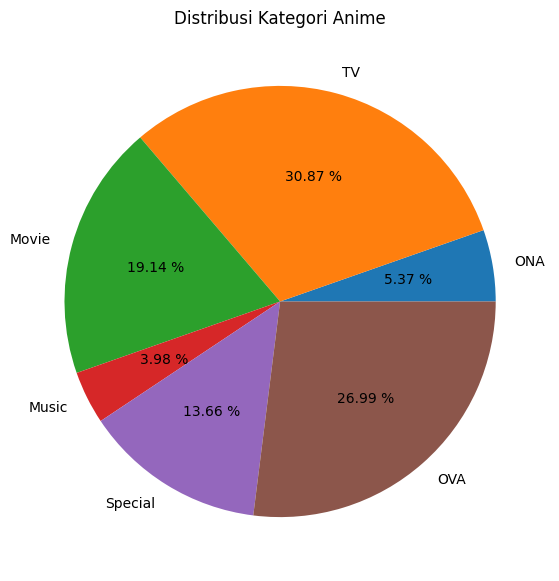

In [ ]:
# visualisasi type dari anime_df
movie = anime_df.loc[anime_df['type'] == 'Movie'].count()[0]
tv = anime_df.loc[anime_df['type'] == 'TV'].count()[0]
ova = anime_df.loc[anime_df['type'] == 'OVA'].count()[0]
special = anime_df.loc[anime_df['type'] == 'Special'].count()[0]
music = anime_df.loc[anime_df['type'] == 'Music'].count()[0]
ona = anime_df.loc[anime_df['type'] == 'ONA'].count()[0]

labels = ['ONA', 'TV', 'Movie', 'Music', 'Special', 'OVA']

plt.figure(figsize = (10,7))
plt.title('Distribusi Kategori Anime')
plt.pie([ona, tv, movie, music, special, ova],
        labels = labels,
        autopct = '%.2f %%'
        )

plt.show()


Dari visualisasi diatas, diketahui bahwa animasi dengan format durasi panjang atau serial (TV dan OVA) mendominasi dengan proporsi sebesar 30.87% dan 26.99%.

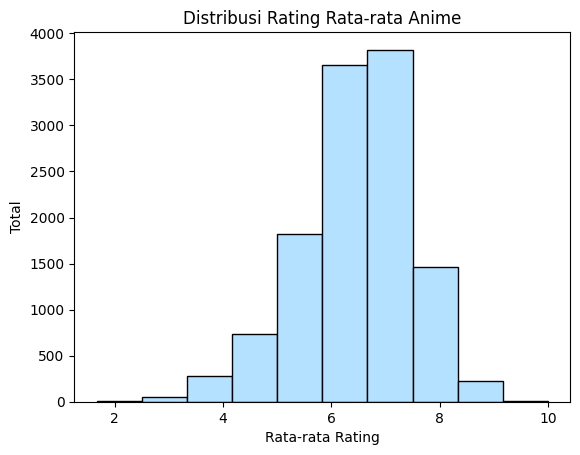

In [ ]:
# visualisasi Distribusi Rating Rata-rata Anime
plt.hist(anime_df.rating, color='#B4E1FF', edgecolor='black')
plt.ylabel('Total')
plt.xlabel('Rata-rata Rating')
plt.title("Distribusi Rating Rata-rata Anime")
plt.show()

Dari visualisasi distribusi rating rata-rata anime, dapat kita ketahui bahwa mayoritas anime memiliki rating rata-rata di kisaran 6 hingga 8, dengan puncak distribusi berada di sekitar 7

In [ ]:
# top 10 komunitas anime
anime_df.sort_values(by='members', ascending=False).head(10)

,anime_id,name,genre,type,episodes,rating,members
40,1535,Death Note,"Mystery, Police, Psychological, Supernatural, ...",TV,37,8.71,1013917
86,16498,Shingeki no Kyojin,"Action, Drama, Fantasy, Shounen, Super Power",TV,25,8.54,896229
804,11757,Sword Art Online,"Action, Adventure, Fantasy, Game, Romance",TV,25,7.83,893100
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
159,6547,Angel Beats!,"Action, Comedy, Drama, School, Supernatural",TV,13,8.39,717796
19,1575,Code Geass: Hangyaku no Lelouch,"Action, Mecha, Military, School, Sci-Fi, Super...",TV,25,8.83,715151
841,20,Naruto,"Action, Comedy, Martial Arts, Shounen, Super P...",TV,220,7.81,683297
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
445,10620,Mirai Nikki (TV),"Action, Mystery, Psychological, Shounen, Super...",TV,26,8.07,657190
131,4224,Toradora!,"Comedy, Romance, School, Slice of Life",TV,25,8.45,633817


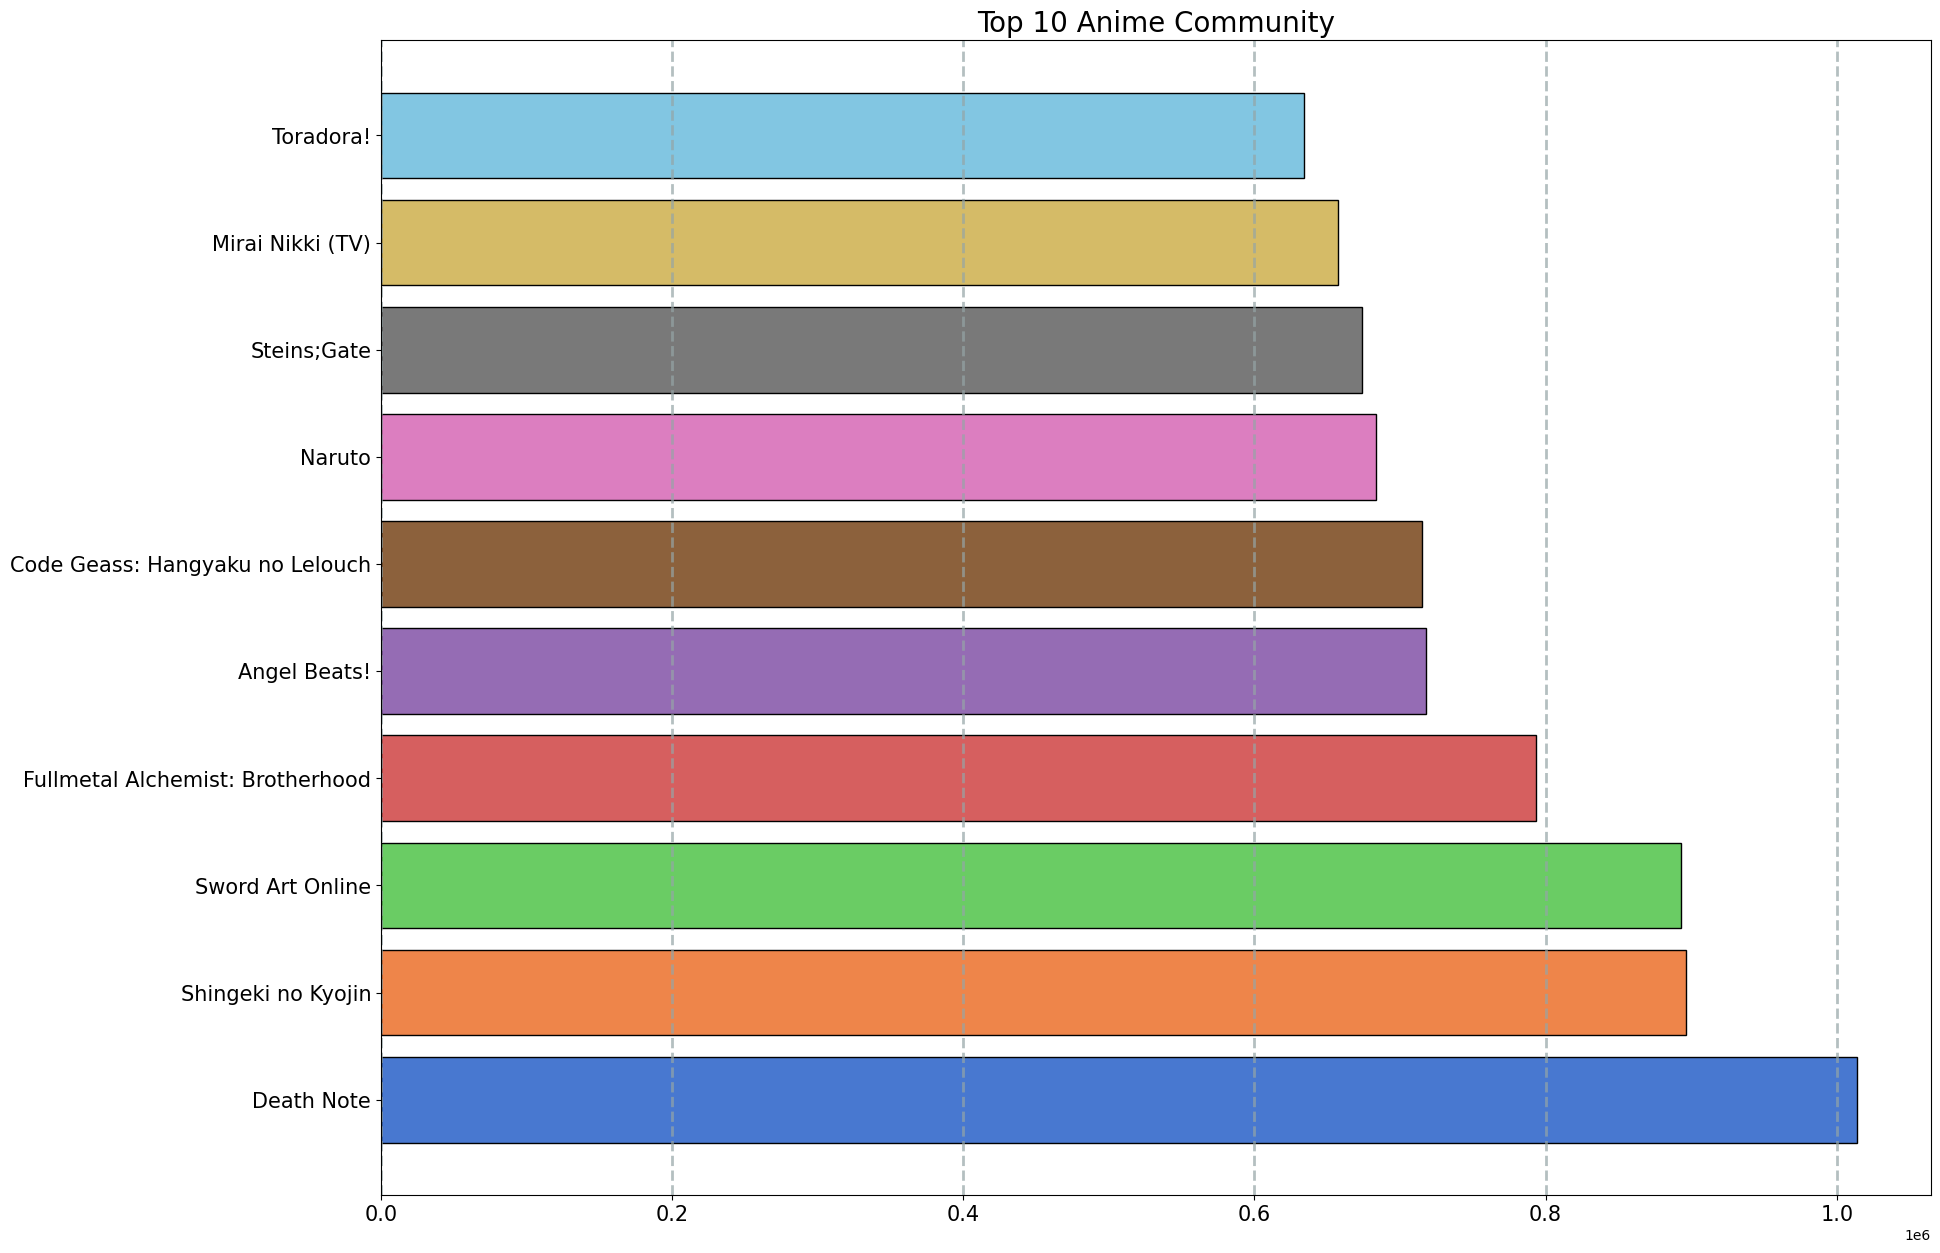

In [ ]:
# visualisasi top 10 komunitas anime
# Menggunakan palet warna Seaborn
colors = sns.color_palette("muted", n_colors=10)  # Palet 'muted' dengan 10 warna
plt.figure(figsize=(20, 15))

# Data
top10_anime = anime_df[['name', 'members']].sort_values(by='members', ascending=False).head(10)
labels = top10_anime['name'].values.flatten()
values = top10_anime['members'].values.flatten()

# Horizontal bar plot dengan warna dari palet
plt.barh(labels, values, color=colors, edgecolor='black')
plt.grid(color='#95a5a6', linestyle='--', linewidth=2, axis='x', alpha=0.7)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.title("Top 10 Anime Community", fontdict={'fontsize': 20})
plt.show()


Dari hasil menampilkan 10 peringkat teratas anime yang memiliki jumlah
 anggota komunitas terbanyak diketahui bahwa anime dengan judul Death Note memiliki jumlah anggota kominitas terbanyak.

In [ ]:
# top 10 anime berdasarkan rating
anime_df.sort_values(by='rating', ascending=False).head(10)

,anime_id,name,genre,type,episodes,rating,members
10464,33662,Taka no Tsume 8: Yoshida-kun no X-Files,"Comedy, Parody",Movie,1,10.00,13
10400,30120,Spoon-hime no Swing Kitchen,"Adventure, Kids",TV,Unknown,9.60,47
9595,23005,Mogura no Motoro,Slice of Life,Movie,1,9.50,62
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
9078,33607,Kahei no Umi,Historical,Movie,1,9.33,44
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
10786,26313,Yakusoku: Africa Mizu to Midori,"Drama, Kids",OVA,1,9.25,53
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266


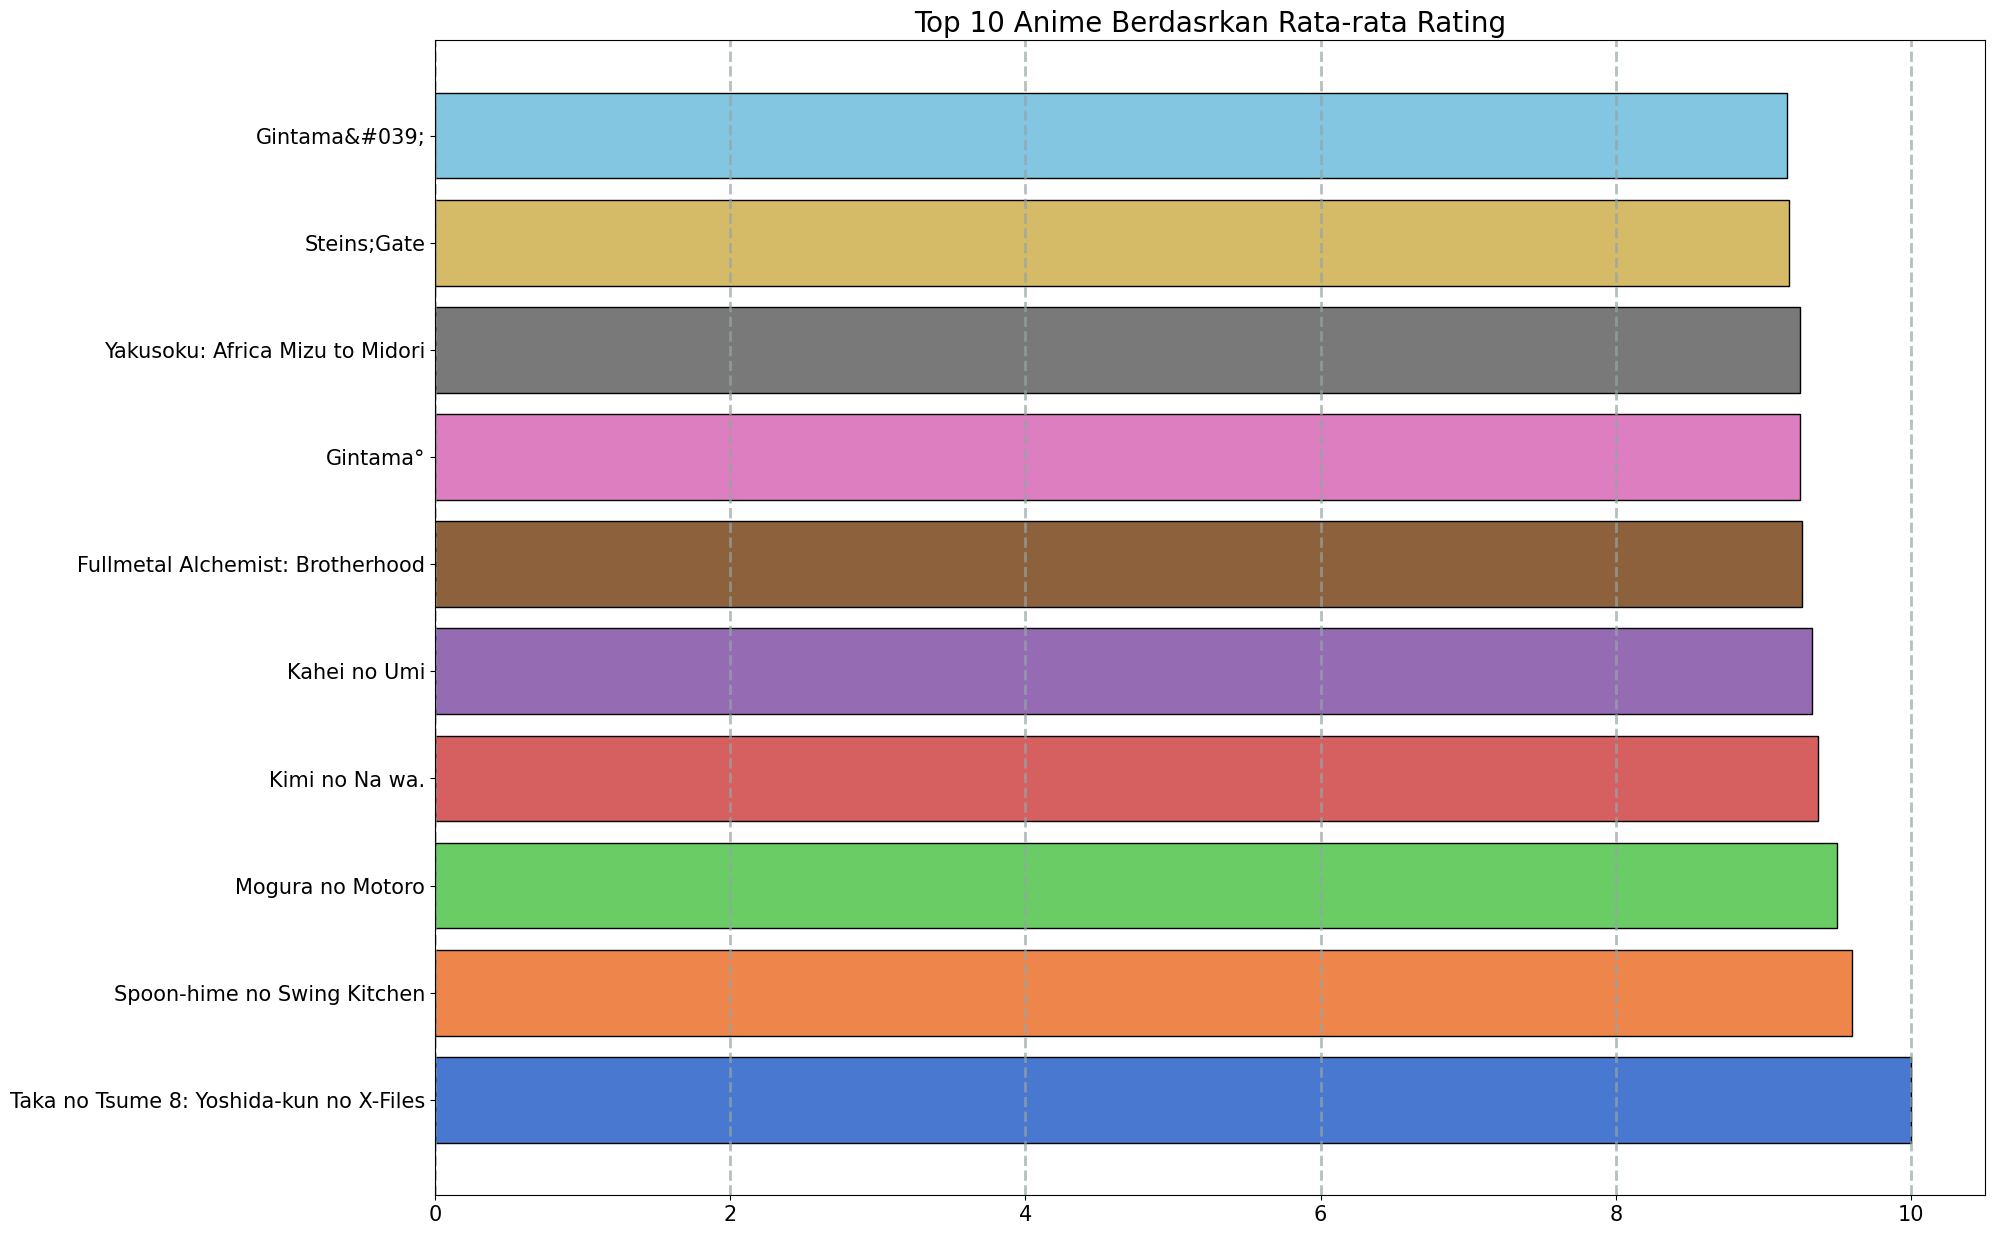

In [ ]:
# visualisasi top 10 anime dengan rata-rata rating tertinggi
colors = sns.color_palette("muted", n_colors=10)  # Palet 'muted' dengan 10 warna
plt.figure(figsize=(20, 15))

# Data
top10_anime = anime_df[['name', 'rating']].sort_values(by='rating', ascending=False).head(10)
labels = top10_anime['name'].values.flatten()
values = top10_anime['rating'].values.flatten()

# Horizontal bar plot dengan warna dari palet
plt.barh(labels, values, color=colors, edgecolor='black')
plt.grid(color='#95a5a6', linestyle='--', linewidth=2, axis='x', alpha=0.7)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.title("Top 10 Anime Berdasrkan Rata-rata Rating", fontdict={'fontsize': 20})
plt.show()

dapat diketahui bahwa anime Taka no Tsume 8 Yoshidakun no XFiles menempati urutan teratas dalam kategori anime yang memiliki rata-rata rating tertinggi.

# Data Preparation

In [ ]:
#cek missing value pada anime_df
anime_df.isnull().sum()

,0
anime_id,0
name,0
genre,62
type,25
episodes,0
rating,230
members,0


Setelah melakukan pengecekan *missing value* pada *dataset* anime_df diketahui pada kolom `genre`, `type`, dan `rating` terdapat *missing value* untuk itu selanjutnya akan dilakukan penghapusan *missing value* menggunakan *method* `dropna()`

In [ ]:
# menghapus missing value pada anime_df
anime_df = anime_df.dropna()

In [ ]:
# cek apakah masih ada missing value
anime_df.isnull().sum()

,0
anime_id,0
name,0
genre,0
type,0
episodes,0
rating,0
members,0


In [ ]:
# cek data duplikat pada dataset  anime_df
print('Jumlah duplikat data anime: ', anime_df.duplicated().sum())

Jumlah duplikat data anime:  0


setelah melakukan pengecekan data duplikat pada *dataset* , diketahui bahwa terdapat tidak terdapat data duplikat pada dataset.

In [ ]:
anime_df['name']

,name
0,Kimi no Na wa.
1,Fullmetal Alchemist: Brotherhood
2,Gintama°
3,Steins;Gate
4,Gintama&#039;
...,...
12289,Toushindai My Lover: Minami tai Mecha-Minami
12290,Under World
12291,Violence Gekiga David no Hoshi
12292,Violence Gekiga Shin David no Hoshi: Inma Dens...


In [ ]:
# menghapus simbol pada judul anime (text cleaning)
# function untuk text cleaning
def text_cleaning(text):
    text = re.sub(r'&', 'and', text)  # Ganti '&' dengan 'and'
    text = re.sub(r"['\"]", '', text)  # Hapus tanda kutip (single/double)
    text = re.sub(r'[^\w\s]', '', text)  # Hapus semua karakter non-alfanumerik kecuali spasi
    text = re.sub(r'\s+', ' ', text).strip()     # Bersihkan spasi ekstra
    return text

anime_df['name'] = anime_df['name'].apply(text_cleaning)

*function* `text_clening` ini bertujuan untuk melakukan pembersihan teks, khussunya judul anime (`name`), dengan menghapus simbol-simbol atau karakter yang tidak diinginkan serta menyederhakan teks agar lebih terstruktur dan mudah diproses.

In [ ]:
anime_df['name']

,name
0,Kimi no Na wa
1,Fullmetal Alchemist Brotherhood
2,Gintama
3,SteinsGate
4,Gintamaand039
...,...
12289,Toushindai My Lover Minami tai MechaMinami
12290,Under World
12291,Violence Gekiga David no Hoshi
12292,Violence Gekiga Shin David no Hoshi Inma Densetsu


Setelah dilakukan *text cleaning*, simbol dan karakter telah dihapus dan judul anime menjadi lebih sederhanan dan terstruktur.

# Model Development

Pada proyek ini, hanya akan digunakan Model Cosine Similarity dan K-Nearest Neighbor. Kedua algoritma tersebut bertujuan untuk mempelajari tingkat kesamaan antar data berdasarkan fitur yang tersedia. Sebelum melakukan model development, dilakuakn ekstraksi fitur menggunakan `TF-IDF`.


In [ ]:
anime_df

,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
1,5114,Fullmetal Alchemist Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
2,28977,Gintama,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
3,9253,SteinsGate,"Sci-Fi, Thriller",TV,24,9.17,673572
4,9969,Gintamaand039,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266
...,...,...,...,...,...,...,...
12289,9316,Toushindai My Lover Minami tai MechaMinami,Hentai,OVA,1,4.15,211
12290,5543,Under World,Hentai,OVA,1,4.28,183
12291,5621,Violence Gekiga David no Hoshi,Hentai,OVA,4,4.88,219
12292,6133,Violence Gekiga Shin David no Hoshi Inma Densetsu,Hentai,OVA,1,4.98,175


In [ ]:
# menghapus kolom yang tidak diperlukan
data = anime_df.drop(columns=['anime_id',
                              'episodes',
                              'members'])
data

,name,genre,type,rating
0,Kimi no Na wa,"Drama, Romance, School, Supernatural",Movie,9.37
1,Fullmetal Alchemist Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,9.26
2,Gintama,"Action, Comedy, Historical, Parody, Samurai, S...",TV,9.25
3,SteinsGate,"Sci-Fi, Thriller",TV,9.17
4,Gintamaand039,"Action, Comedy, Historical, Parody, Samurai, S...",TV,9.16
...,...,...,...,...
12289,Toushindai My Lover Minami tai MechaMinami,Hentai,OVA,4.15
12290,Under World,Hentai,OVA,4.28
12291,Violence Gekiga David no Hoshi,Hentai,OVA,4.88
12292,Violence Gekiga Shin David no Hoshi Inma Densetsu,Hentai,OVA,4.98


Proses penghapusan kolom `anime_id`, `episodes`, dan `members` dilakukan karena kolom-kolom tersebut tidak relevan untuk analisis atau prediksi yang diinginkan pada proyek ini.

**Model Content Based Filtering(dengan filter genre)**

**TF-IDF**
 TF-IDF akan mentransformasikan teks menjadi representasi angka yang memiliki makna tertentu dalam bentuk matriks.

In [ ]:
# membuat objek tfidf
tfidf = TfidfVectorizer()
tfidf.fit(data['genre'])
tfidf.get_feature_names_out()

array(['action', 'adventure', 'ai', 'arts', 'cars', 'comedy', 'dementia',
       'demons', 'drama', 'ecchi', 'fantasy', 'fi', 'game', 'harem',
       'hentai', 'historical', 'horror', 'josei', 'kids', 'life', 'magic',
       'martial', 'mecha', 'military', 'music', 'mystery', 'of', 'parody',
       'police', 'power', 'psychological', 'romance', 'samurai', 'school',
       'sci', 'seinen', 'shoujo', 'shounen', 'slice', 'space', 'sports',
       'super', 'supernatural', 'thriller', 'vampire', 'yaoi', 'yuri'],
      dtype=object)

In [ ]:
# mengubah teks menjadi matriks
tfidf_matrix = tfidf.fit_transform(data['genre'])
tfidf_matrix.shape

(12017, 47)

In [ ]:
# mengubah matriks sparse menjadi matriks dua dimensi (dense)
tfidf_matrix.todense()

matrix([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.29498527, 0.3162867 , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.2516182 , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        ...,
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ]])

In [ ]:
#membuat dataframe dengan hasil tf-idf
pd.DataFrame(
    tfidf_matrix.todense(),
    columns=tfidf.get_feature_names_out(),
    index=data.genre
).sample(22, axis=1).sample(10, axis=0)

,fi,adventure,sports,ecchi,psychological,kids,police,life,mystery,historical,...,action,slice,seinen,magic,drama,dementia,thriller,harem,comedy,romance
genre,,,,,,,,,,,,,,,,,,,,,
"Action, Adventure, Comedy, Ecchi, Mecha, Military, Romance, Sci-Fi",0.293485,0.279863,0.0,0.417768,0.0,0.0,0.000000,0.00000,0.000000,0.0,...,0.261015,0.00000,0.0,0.0,0.000000,0.0,0.0,0.0,0.207886,0.330314
"Drama, Mecha, Sci-Fi, Shounen",0.415930,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.00000,0.000000,0.0,...,0.000000,0.00000,0.0,0.0,0.420336,0.0,0.0,0.0,0.000000,0.000000
"Adventure, Drama, Fantasy, Sci-Fi",0.453498,0.432449,0.0,0.000000,0.0,0.0,0.000000,0.00000,0.000000,0.0,...,0.000000,0.00000,0.0,0.0,0.458301,0.0,0.0,0.0,0.000000,0.000000
"Adventure, Fantasy, Music, Romance",0.000000,0.433234,0.0,0.000000,0.0,0.0,0.000000,0.00000,0.000000,0.0,...,0.000000,0.00000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.511333
Psychological,0.000000,0.000000,0.0,0.000000,1.0,0.0,0.000000,0.00000,0.000000,0.0,...,0.000000,0.00000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000
"Adventure, Fantasy",0.000000,0.702783,0.0,0.000000,0.0,0.0,0.000000,0.00000,0.000000,0.0,...,0.000000,0.00000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000
"Action, Comedy, Mystery, Police",0.000000,0.000000,0.0,0.000000,0.0,0.0,0.697272,0.00000,0.573507,0.0,...,0.336356,0.00000,0.0,0.0,0.000000,0.0,0.0,0.0,0.267891,0.000000
Music,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.00000,0.000000,0.0,...,0.000000,0.00000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000
Slice of Life,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.57735,0.000000,0.0,...,0.000000,0.57735,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000


hasil TF-IDF diatas menunjukkan hubungan antara nama anime terhadap kategori yang dipilih. Matriks ini menunjukkan seberapa besar korelasi antara anime terhadap kategori yang dipilih.

**Cosine Similarity**

Cosine Similarity adalah sebuah metode yang digunakan untuk mengukur seberapa mirip dua vektor dalam ruang vektor. Ukuran ini dihitung dengan menghitung sudut antara dua vektor, di mana dua vektor yang lebih mirip memiliki sudut yang lebih kecil, dan sebaliknya. Cosine Similarity sering digunakan dalam analisis teks untuk mengukur kesamaan antar dokumen.

**Rumus Cosine Similarity**

Rumus untuk menghitung Cosine Similarity antara dua vektor **A** dan **B** adalah sebagai berikut:

$$Cosine Similarity (A, B) = (A · B) / (||A|| * ||B||)$$

dimana:

- (A·B)menyatakan produk titik dari vektor A dan B.
- ||A|| mewakili norma Euclidean (magnitudo) dari vektor A.
- ||B|| mewakili norma Euclidean (magnitudo) dari vektor B.
  untuk melakukan pengujian model, digunakan potongan kode berikut.

In [ ]:
# menghitung cosine similarity pada matrix tf-idf
cosine_sim = cosine_similarity(tfidf_matrix)
cosine_sim

array([[1.        , 0.14715318, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.14715318, 1.        , 0.17877808, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.17877808, 1.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 1.        , 1.        ,
        1.        ],
       [0.        , 0.        , 0.        , ..., 1.        , 1.        ,
        1.        ],
       [0.        , 0.        , 0.        , ..., 1.        , 1.        ,
        1.        ]])

In [ ]:
# Membuat dataframe dari variabel cosine_sim dengan baris dan kolom berupa nama anime
cosine_sim_df = pd.DataFrame(cosine_sim, index=data['name'], columns=data['name'])
print('Shape:', cosine_sim_df.shape)

# Melihat similarity matrix pada setiap anime
cosine_sim_df.sample(5, axis=1).sample(10, axis=0)

Shape: (12017, 12017)


name,Balgwanghaneun Hyeondaesa,Fly,Lupin III Kiri no Elusive,Yubisaki Annainin Shirudaku Settai Okawari Sanhaime,Mahou Shoujo Lyrical Nanoha The Movie 2nd Aand039s
name,,,,,
Arigatou Kumanofu,0.000000,0.000000,0.388971,0.000000,0.237097
Magical Witch Academy Boku to Sensei no Magical Lesson The Animation,0.000000,0.000000,0.000000,1.000000,0.000000
Hello Lady Lynn,1.000000,0.000000,0.000000,0.000000,0.338270
Unbalance,0.000000,0.000000,0.000000,1.000000,0.000000
Chiisana Kinomi,0.000000,0.000000,0.000000,0.000000,0.000000
Yumemiru Topo Gigio,0.000000,0.000000,0.481183,0.000000,0.104292
One Piece,0.319127,0.304819,0.575055,0.000000,0.747611
Hotaruko,0.000000,0.000000,0.000000,1.000000,0.000000
Gibo,0.521538,0.000000,0.000000,0.625004,0.176421


In [ ]:
# membuat function untuk mendapatkan rekomendasi anime
def anime_recommendations(name, similarity_data=cosine_sim_df, items=data[['name','genre']], k=5):


    index = similarity_data.loc[:,name].to_numpy().argpartition(
        range(-1, -k, -1))


    closest = similarity_data.columns[index[-1:-(k+2):-1]]
    closest = closest.drop(name, errors='ignore')

    return pd.DataFrame(closest).merge(items).head(k)

In [ ]:
# menemukan rekomendasi anime yang mirip dengan SteinsGate
data[data.name.eq('SteinsGate')]

,name,genre,type,rating
3,SteinsGate,"Sci-Fi, Thriller",TV,9.17


In [ ]:
anime_recommendations('SteinsGate')

,name,genre
0,SteinsGate Kyoukaimenjou no Missing Link Divid...,"Sci-Fi, Thriller"
1,SteinsGate Movie Fuka Ryouiki no Déjà vu,"Sci-Fi, Thriller"
2,SteinsGate Oukoubakko no Poriomania,"Sci-Fi, Thriller"
3,Ibara no Ou,"Action, Mystery, Sci-Fi, Thriller"
4,LoupsGarous,"Mystery, Sci-Fi, Thriller"


Sistem telah berhasil merekomendasikan top 5 persen anime yang mirip dengan SteinsGate, yaitu beberapa seri dan film dari SteinsGate itu sendiri. Jadi, jika pengguna menyukai SteinsGate, maka sisrem dapat merekomendasikan seri atau movie SteinsGate lainnya.

**Model K-Nearest Neighbor**

K-Nearest Neighbors (K-NN) adalah algoritma pembelajaran mesin yang digunakan untuk klasifikasi dan regresi. Dalam K-NN, data yang ingin diprediksi dikategorikan berdasarkan mayoritas label dari _K_ tetangga terdekatnya di ruang fitur. Untuk menentukan tetangga terdekat, biasanya digunakan jarak antara data titik dengan data lainnya. Salah satu metrik jarak yang sering digunakan adalah _Euclidean Distance_.

**Rumus Euclidean Distance**

$$Euclidean Distance (P, Q) = sqrt(∑(Pi - Qi)^2)$$

dimana:

- Pi mewakili fitur ke-i dari titik data P.
- Qi mewakili fitur ke-i dari titik data Q (titik data dari kumpulan data D).
- ∑ merupakan simbol penjumlahan pada semua fitur titik data.

In [ ]:
anime_name = pd.DataFrame({'Name': data['name']})
anime_name.head()

,Name
0,Kimi no Na wa
1,Fullmetal Alchemist Brotherhood
2,Gintama
3,SteinsGate
4,Gintamaand039


In [ ]:
data.set_index('name', inplace=True)

In [ ]:
datas = data[['type', 'rating']]

In [ ]:
new_data = pd.get_dummies(datas['type']).astype(int)
new_data = pd.concat([datas, new_data], axis=1)
new_data = new_data.drop(columns='type')
new_data.head()

,rating,Movie,Music,ONA,OVA,Special,TV
name,,,,,,,
Kimi no Na wa,9.37,1,0,0,0,0,0
Fullmetal Alchemist Brotherhood,9.26,0,0,0,0,0,1
Gintama,9.25,0,0,0,0,0,1
SteinsGate,9.17,0,0,0,0,0,1
Gintamaand039,9.16,0,0,0,0,0,1


kode ini berguna untuk mengonversi data kategorikal dalam kolom `type` menjadi represntasi numerik (one-hot encoding).

In [ ]:
# model K-NN
model = NearestNeighbors(metric='euclidean')
model.fit(new_data)

NearestNeighbors(metric='euclidean')

In [ ]:
def Recommended_model(name:str, recommend_anime:int=5):
  print(f'Apabila pengguna menyukai anime dengan judul:{name[0]} \nBerikut rekomendasi anime yang  mungkin akan disukai :')
  distances, neighbors = model.kneighbors(new_data.loc[name],n_neighbors=recommend_anime)
  similar_anime = []
  for names_anime in anime_name.loc[neighbors[0][:]].values:
    similar_anime.append(names_anime[0])
  similar_distance = []
  for distance in distances[0]:
    similar_distance.append(f"{round(100-distance, 2)}%")
  return pd.DataFrame(data = {"Anime Name" : similar_anime, "Similiarity Score" : similar_distance})


In [ ]:
Recommended_model(anime_name.loc[70])

Apabila pengguna menyukai anime dengan judul:Bakemono no Ko 
Berikut rekomendasi anime yang  mungkin akan disukai :


<ipython-input-43-0887c68d89e4>:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(f'Apabila pengguna menyukai anime dengan judul:{name[0]} \nBerikut rekomendasi anime yang  mungkin akan disukai :')


,Anime Name,Similiarity Score
0,Hotaru no Haka,100.0%
1,Bakemono no Ko,100.0%
2,Gintama Movie Shinyaku Benizakurahen,99.99%
3,Kara no Kyoukai 7 Satsujin Kousatsu Kou,99.99%
4,Gintama Yorinuki Gintamasan on Theater 2D,99.98%


Hasil Pengujian Model K-NN, kita dapat melihat bahwa model K-Nearest Neighbor memberikan rekomendasi Anime berdasarkan kemiripan fitur-fitur seperti 'Name', 'Score', dan 'Type'. Hasil rekomendasi untuk Anime yang mirip dengan Bakemono no Ko berdasarkan berdasarkan fitur-fitur yang dipelajari memberikan hasil rekomendasi anime serupa yaitu: Hotaru no Haka, Bakemono no Ko, Gintama Movie Shinyaku Benizakurahen, Kara no Kyoukai 7 Satsujin Kousatsu Kou , dan Gintama Yorinuki Gintamasan on Theater 2D. Seperti yang terlihat pada Gambar 7. Hasil Pengujian Model K-Nearest Neighbor dengan tingkat kemiripan dalam persentase berturut-turut senilai 100.0%, 100.0%, 99.99%, 99.99%, 99.98% . Tentunya model ini akan sangat membantu pengguna menemukan anime yang mirip dengan Bakemono no Ko.

# Evaluasi Model

**Calinski-Harabasz score**

Clinski-Harabasz Score (juga dikenal sebagai Variance Ratio Criterion) adalah salah satu metrik evaluasi dalam analisis klaster (clustering). Metrik ini digunakan untuk menilai kualitas hasil klaster yang dihasilkan oleh algoritma clustering seperti k-means, hierarchical clustering, atau lainnya. Metrik ini mengukur seberapa baik klaster yang terbentuk terpisah satu sama lain dan seberapa homogen setiap klaster. Semakin tinggi nilai CH Score, semakin baik kualitas pemisahan dan homogenitas klaster yang terbentuk.

**Rumus**

Calinski-Harabasz Score dihitung menggunakan rumus berikut:

$$CH = \frac{B}{W} \times \frac{N - k}{k - 1}$$

Di mana:

- \( B \) adalah sebaran antar cluster (between-cluster scatter).
- \( W \) adalah sebaran dalam cluster (within-cluster scatter).
- \( N \) adalah jumlah total data.
- \( k \) adalah jumlah cluster.

Nilai Calinski-Harabasz Score yang lebih tinggi menunjukkan bahwa klaster yang terbentuk lebih terpisah dengan lebih sedikit variasi dalam setiap klaster, yang menandakan hasil klasterisasi yang lebih baik.

In [ ]:
ch_score = calinski_harabasz_score(new_data, anime_name)
print(f'Calinski-Harabasz Score: {ch_score}')

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Calinski-Harabasz Score: 5.0031370256340795


Hasil evaluasi model menggunakan Calinski-Harabasz Score berada di angka 5.0031370256340795. Angka ini tergolong rendah yang menunjukan bahwa kluster dalam model ini masih belum terpisah dengan baik. Hal ini mengindikasikan adanya potensi untuk rekomendai yang kurang sesuai dengan prederensi pengguna. Oleh karena itu, perlu dilakukan penijauan lebih lanjut atau penyesuaian pada model untuk meningkatkan akurasi dan pemisahan kluster.


**Davies Bouldin Score**

Davies-Bouldin Score adalah metrik evaluasi yang digunakan untuk menilai kualitas hasil clustering dalam analisis data. Metrik ini mengukur seberapa baik suatu klaster terpisah satu sama lain, dengan memperhitungkan jarak antar klaster dan keberagaman dalam klaster.

Nilai DB Score dihitung berdasarkan dua faktor utama:

1. **Kepadatan Klaster**: Mengukur sejauh mana data dalam klaster tersebut tersebar.
2. **Jarak antar Klaster**: Mengukur jarak antara pusat klaster yang berbeda.

Semakin kecil DB Score, semakin baik pemisahan antar klaster, yang berarti klaster-klaster tersebut lebih padat dan lebih terpisah.

**Rumus**

Rumus untuk menghitung Davies-Bouldin Score adalah:

$$ DB = \frac{1}{N} \sum*{i=1}^{N} \max*{i \neq j} \left( \frac{s*i + s_j}{d*{ij}} \right) $$

Dimana:

- \( s_i \) adalah jarak rata-rata antara titik dalam klaster \( i \) dengan pusat klaster \( i \),
- \( d\_{ij} \) adalah jarak antara pusat klaster \( i \) dan pusat klaster \( j \),
- \( N \) adalah jumlah klaster.


In [ ]:
db_score = davies_bouldin_score(new_data, anime_name)
print(f'Davies-Bouldin Score: {db_score}')

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Davies-Bouldin Score: 1.7266309883660804


Nilai `1.7266` ini relatif tinggi, yang menunjukkan bahwa klaster-klaster yang dihasilkan tidak terlalu terpisah dengan jelas atau ada beberapa klaster yang mungkin tumpang tindih satu sama lain. Metrik ini mengindikasikan adanya overlap antar klaster, atau klaster-klaster tersebut mungkin tidak cukup kompak (terlalu tersebar), yang menyebabkan klaster saling mendekat atau bahkan bertumpuk. Namun, dalam hal memberikan rekomendasi anime yang baik pada sistem rekomendasi. Hal ini karena Davies-Bouldin Score memberikan gambaran tentang kualitas pemisahan antar klaster, sistem rekomendasi tidak selalu bergantung sepenuhnya pada pemisahan klaster yang sangat jelas.